# Building a data loader

The objective of this notebook is to use Matthieu's work to build a reusable notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Matching our images with their categories in `y_target`

In [2]:
# Reading the target file 
raw_y_target = pd.read_csv('data/target_value.csv', low_memory=False)
raw_y_target['code'] = raw_y_target['code'].astype(str) # preventing the '0's at the beginning of the 'code' from being removed
raw_y_target.set_index(['code'],inplace=True)
raw_y_target.head()

,Barquette,Bocal,Boite,Bouteille,Brique,Carton,Conserve,Metal,Papier,Plastique,Pot,Sachet,Verre
code,,,,,,,,,,,,,
85,0,0,0,0,0,0,0,0,0,1,0,0,0
133,0,0,0,0,0,0,0,0,0,0,0,0,1
1151,1,0,1,0,0,1,0,0,0,1,0,0,0
1202,0,0,0,0,0,0,0,0,0,1,0,1,0
1426,0,0,0,0,0,0,0,1,0,0,0,0,0


Before running the following cells, make sure you have unrared the file x_sample.rar in a folder `/data/images`.

In [3]:
# Filtering y_target so it only contains the images in the folder data/images
image_names = os.listdir('data/images')
image_names =  [name.replace('.jpg', '') for name in image_names] # removing the extension from the name
y_target = raw_y_target.loc[image_names,:] # filtering y_target on the images we have

In [4]:
# Verifying that all our images have been matched in y_target
y_target.shape[0] == len(image_names)

True

### 2. Building the Data Loader

First, we are building a dataset compatible with multi labelling.

In [5]:
class MultiLabelDataset(Dataset):
    def __init__(self, df, root_dir_img, transform=None):
        """
        Args:
            df(pandas dataframe):           Target dataframe with class one hot encoded and index name of the images.
            root_dir_img (string):          Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = df
        self.root_dir_img = root_dir_img
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir_img, str(self.df.index[idx])+'.jpg')
        img = Image.open(img_name)
        img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
            
        label = torch.Tensor(self.df.iloc[idx].tolist())

        return img, label

Next, we transform and format our images.

In [6]:
# Specifying the transformations to apply to our images
transformer = transforms.Compose([
                # 1. Resizing the images so they all have the same format
                transforms.Resize((224,224)),
                # 2. Converting to Tensor
                transforms.ToTensor()
            ])

# Applying the transformations
train = MultiLabelDataset(df=y_target, root_dir_img='data/images', transform=transformer)

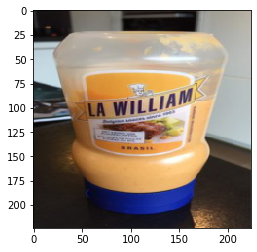

In [7]:
# Plotting an image
index_image = 20
plt.figure()
plt.imshow(np.dstack(train[index_image][0].numpy()))
plt.show()

Finally, we can create our dataloader.

In [8]:
train_loader = DataLoader(train,
                          batch_size=16,
                          shuffle=True,
                          num_workers=0)

### 3. Testing the Data Loader on a model

In [ ]:
## Multi label NN - architecture at random 
class MultiLabelNN(nn.Module):
    def __init__(self, nlabel):
        super(MultiLabelNN, self).__init__()
        self.nlabel = nlabel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2876416,24)
        #self.fc1 = nn.Linear(224*224*3,24)
        self.fc2 = nn.Linear(24, nlabel)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        # x = self.pool(x)
        #x = x.view(-1, 3*224*224)
        x = x.view(-1, 2876416)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
## run the model on train only - only work with GPU... see error below
use_gpu = torch.cuda.is_available()
model = MultiLabelNN(13)
if use_gpu:
    model = model.cuda()


optimizer = optim.SGD(model.parameters(), lr=0.0001)
criterion = torch.nn.MultiLabelMarginLoss()

epochs = 3
for epoch in range(epochs):
    ### training phase
    total_training_loss = 0.0
    for iter, traindata in enumerate(train_loader, 0):
        train_inputs, train_labels = traindata
        if use_gpu:
            train_inputs, train_labels = Variable(train_inputs.cuda()), Variable(train_labels.cuda())
        else: train_inputs, train_labels = Variable(train_inputs), Variable(train_labels)

        optimizer.zero_grad()

        train_outputs = model(train_inputs)
        loss = criterion(train_outputs.long(), train_labels.long())
        loss.backward()
        optimizer.step()

        # total += train_labels.size(0)
        total_training_loss += loss.data[0]
        print('Training Phase: Epoch: [%2d][%2d/%2d]\tIteration Loss: %.3f' %
              (iter, epoch, epochs, loss.data[0] / train_labels.size(0)))
